In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
loc = 'drive/My Drive/Signature_Verification'

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats

from data_processing import *

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dropout


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPool2D,Concatenate,Lambda,Flatten,Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.models import Model

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

In [ ]:
os.listdir()

['.config',
 '__pycache__',
 '.ipynb_checkpoints',
 'BHSig260.zip',
 'lossval_loss_3.png',
 'drive',
 'data_processing.py',
 'sample_data']

# Dataset Generation

## Importing Data

In [4]:
imgsize = (150,150)
size= 150
path_dataset1 = os.path.join(loc,'Signature_Set1')
path_dataset2 = os.path.join(loc,'Signature_Set2')
path_dataset3 = os.path.join(loc,'Signature_Set3') 
path_dataset4 = os.path.join(loc,'Signature_Set4')
images_dictionary = {} # This dictionary stores all the images, to avoid too much memory consumption

In [ ]:
# Para las FORMAS  se debe comentar esta sección de código.

fname = 'BHSig260.zip'

### Dataset from Set-1

In [5]:
real_img,forged_img = getImages(path_dataset1,imgsize,images_dictionary)
real_img = np.sort(real_img)
forged_img = np.sort(forged_img)
set1_X1,set1_X2,set1_Y = makePairs(real_img,forged_img,5)
print(len(set1_X1),len(set1_X2),len(set1_Y))

Getting Dataset-1 Data and Saving inside the Dictionary..
Getting Genuine Images..
25% Completed..
50% Completed..
100% Completed
Getting Forged Images..
25% Completed..
50% Completed..
100% Completed
600 600 600


### Dataset from Set-2

In [6]:
real_img,forged_img = getImages2(path_dataset2,imgsize,images_dictionary)
real_img = np.sort(real_img)
forged_img = np.sort(forged_img)
set2_X1,set2_X2,set2_Y = makePairs(real_img,forged_img,24)
print(len(set2_X1),len(set2_X2),len(set2_Y))

Getting Dataset2 Data..
25% Completed..
50% Completed..
Couldn't import  Thumbs.db in Location: drive/My Drive/Signature_Verification/Signature_Set2/full_org
100% Completed
25% Completed..
50% Completed..
Couldn't import  Thumbs.db in Location: drive/My Drive/Signature_Verification/Signature_Set2/full_forg
100% Completed
Data Import Complete!
30360 30360 30360


### Dataset from Set-3

In [ ]:
#FORMAS 2 Y 3:
real,forged = getHindi(fname,imgsize,images_dictionary)
X1H,X2H,yH  = makeHindiPairs(real,forged)

Getting Genuine Data..
25% Complete
50% Complete
75% Complete
100% Complete
Getting Forged Data..
25% Complete
50% Complete
75% Complete
100% Complete


### Dataset from Set-4

In [ ]:
#FORMAS 3 Y 4: 
real_img,forged_img = getImages4(path_dataset4,imgsize,images_dictionary)
real_img = np.sort(real_img)
forged_img = np.sort(forged_img)
set4_X1,set4_X2,set4_Y = makePairs(real_img,forged_img,12)
print(len(set4_X1),len(set4_X2),len(set4_Y))

Getting Dataset 4 Data..
25% Completed..
50% Completed..
100% Completed
25% Completed..
50% Completed..
100% Completed
Data Import Complete!
7128 7128 7128


Joining the Set2 and Set3 Datasets

In [ ]:
#OMITIR PARA LA FORMA 1:
X1 = np.concatenate([set2_X1, set4_X1])
X2 = np.concatenate([set2_X2, set4_X2])
Y  = np.concatenate([set2_Y, set4_Y])
print(len(X1),len(X2),len(Y))

37488 37488 37488


#### Shuffling Data

In [ ]:
#OMITIR PARA LA FORMA 1:
import random
random.seed=35
mapIndexPosition = list(zip(X1,X2,Y))
random.shuffle(mapIndexPosition)
X1,X2,Y = zip(*mapIndexPosition)
Y = tf.cast(Y, tf.float32)

In [7]:
#FORMA 1: Entrenamiento únicamente con CEDAR
X1_train = set2_X1[0:24288]
X2_train = set2_X2[0:24288]
Y_train  = set2_Y[0:24288]
X1_val   = set2_X1[24288:]
X2_val   = set2_X2[24288:]
Y_val    = set2_Y[24288:]
#FORMA 2: Entrenamiento con CEDAR + BHSig260
#X1_train = X1[0:173720]
#X2_train = X2[0:173720]
#Y_train  = Y[0:173720]
#X1_val   = X1[173720:]
#X2_val   = X2[173720:]
#Y_val    = Y[173720:]
#FORMA 3: Entrenamiento con CEDAR + BHSig260 + SigComp2011
#X1_train = X1[0:164040]
#X2_train = X2[0:164040]
#Y_train  = Y[0:164040]
#X1_val   = X1[164040:]
#X2_val   = X2[164040:]
#Y_val    = Y[164040:]
#FORMA 4: Entrenamiento con CEDAR + SigComp2011
#X1_train = X1[0:31488]
#X2_train = X2[0:31488]
#Y_train  = Y[0:31488]
#X1_val   = X1[31488:]
#X2_val   = X2[31488:]
#Y_val    = Y[31488:]
print(len(X1_train),len(X2_train),len(Y_train),len(X1_val),len(X2_val),len(Y_val))

24288 24288 24288 6072 6072 6072


## Generating Data

In [8]:
def create_batch(x1,x2,startpoint,batch_size):
    fir=np.zeros((batch_size,imgsize[0],imgsize[0],1))
    sec=np.zeros((batch_size,imgsize[0],imgsize[0],1))
    counter=0
    for i in range(startpoint,startpoint+batch_size):
        fir[counter]=images_dictionary[x1[i]]
        sec[counter]=images_dictionary[x2[i]]
        counter+=1
    return fir,sec

In [9]:
# Function takes in input of array of names, and returns the image list with expanded dimenstions
def returnImageList(name_lis):
    length = len(name_lis)
    imgs = np.zeros((length,imgsize[0],imgsize[0],1))
    for i in range(0,length):
        imgs[i] = images_dictionary[name_lis[i]]
    return imgs

In [10]:
def data_generator(batch_size,x1,x2,y):
    counter=0
    while True:
        if counter>=len(y): counter=0
        a,b = create_batch(x1,x2,counter,batch_size)
        y1 = y[counter:counter+batch_size]
        counter+=batch_size
        yield [a,b],y1

# Preparing the Model

### Embedding Model

In [11]:
emb_dim = 64

embedding_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), input_shape=(size,size,1),name='Layer1'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(2, 2),
  #tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(128, (3,3),name='Layer2'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.1),
    
  tf.keras.layers.Conv2D(256, (3,3),name='Layer3'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(4, 4),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(512, (3,3),name='Layer4'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(4, 4),
  tf.keras.layers.Dropout(0.1),

  tf.keras.layers.Conv2D(512, (1,1),name='Layer5'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Flatten(),
],name='embedding_model')
print(embedding_model.summary())

Model: "embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv2D)             (None, 148, 148, 64)      640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 148, 148, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 64)     592       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 Layer2 (Conv2D)             (None, 72, 72, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 72, 72, 128)   

### Siamese-Type Network

In [12]:
input_a = tf.keras.layers.Input(shape=(size,size,1),name='input1')
input_b = tf.keras.layers.Input(shape=(size,size,1),name='input2')

em_one = embedding_model(input_a)
em_two = embedding_model(input_b)

out = tf.keras.layers.concatenate([em_one,em_two],axis=1)
out = tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.1))(out)
out = tf.keras.layers.Dense(64,activation='relu')(out)

out = tf.keras.layers.Dense(1,activation='sigmoid',name='Output')(out)

model = tf.keras.models.Model([input_a, input_b],out)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input2 (InputLayer)            [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 embedding_model (Sequential)   (None, 512)          1813520     ['input1[0][0]',                 
                                                                  'input2[0][0]']             

### Learning Rate Scheduling

In [13]:
initial_learning_rate = 0.0008
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5, 
    decay_rate=0.96,
    staircase=True
) #lr = lr * (decay_rate ^ decay_steps)
optimizer= tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [14]:
batch_size = 8
epoch = 4
rms = tf.keras.optimizers.RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [15]:
history =model.fit(
    data_generator(batch_size,X1_train,X2_train,Y_train),
    epochs=epoch,
    steps_per_epoch=len(Y_train) // batch_size,
    validation_data=data_generator(batch_size,X1_val,X2_val,Y_val),
    validation_steps = len(Y_val) // batch_size,
    verbose=1
)

Epoch 1/4
3036/3036 [==============================] - 341s 109ms/step - loss: 1.2699 - accuracy: 0.7050 - val_loss: 1.0553 - val_accuracy: 0.6915
Epoch 2/4
3036/3036 [==============================] - 329s 108ms/step - loss: 0.7549 - accuracy: 0.7257 - val_loss: 1.0562 - val_accuracy: 0.6914
Epoch 3/4
3036/3036 [==============================] - 343s 113ms/step - loss: 0.7539 - accuracy: 0.7281 - val_loss: 1.0552 - val_accuracy: 0.6917
Epoch 4/4
3036/3036 [==============================] - 329s 108ms/step - loss: 0.7541 - accuracy: 0.7260 - val_loss: 1.0543 - val_accuracy: 0.6912


# Plotting the Accuracy and Losses



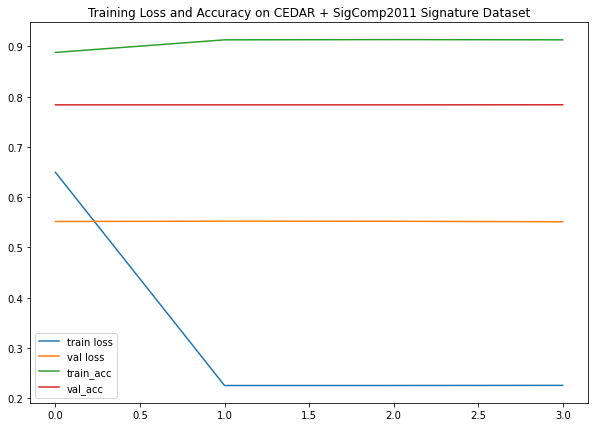

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Training Loss and Accuracy on CEDAR + SigComp2011 Signature Dataset")
plt.legend()
plt.show()
plt.savefig('lossval_loss_3')

# Evaluation

### On Training Set
*(Accuracy suggests that the model has avoided overfitting along with learning)*

In [ ]:
train_set_accuracy = model.evaluate(data_generator(batch_size,X1_train,X2_train,Y_train),batch_size=batch_size,steps=len(Y_val) // batch_size)

750/750 [==============================] - 29s 39ms/step - loss: 0.5539 - accuracy: 0.7775


In [ ]:
print("Training Set Accuracy is : ", train_set_accuracy[1]*100)

Training Set Accuracy is :  77.74999737739563


### On Validation Set
*(Accuracy suggests how well the model has actually learnt)*

In [ ]:
validation_set_accuracy=model.evaluate(data_generator(batch_size,X1_val,X2_val,Y_val),batch_size=batch_size,steps=len(Y_val) // batch_size)

750/750 [==============================] - 28s 37ms/step - loss: 0.5511 - accuracy: 0.7840


In [ ]:
print("Validation Set Accuracy = ",validation_set_accuracy[1]*100)

Validation Set Accuracy =  78.39999794960022


### On Dataset which is totally new for the model
*(Expected Accuracy is very low, just to get an idea on how well the model has learnt)* <br> <br>
 
This Accuracy is calculated based on threshold. Since the result are the probability (by sigmoid activation function), threshold using the **mean** of all the values gave comparatively better accuracy.

In [ ]:
test_preds = model.predict([returnImageList(set1_X1),returnImageList(set1_X2)])

In [ ]:
def calculateAccuracy(Y,predictions,threshold): # Calculates Accuracy on a given threshold value
    test_preds_final = []
    for i in predictions:
        if i[0]<0.35: test_preds_final.append(0)
        else: test_preds_final.append(1)

    counter=0
    for i in range(0,len(set1_Y)):
        if set1_Y[i] == test_preds_final[i]:
            counter+=1
    return counter*100/len(test_preds_final)

In [ ]:
mean = np.mean(test_preds)
print(mean)

0.29331684


In [ ]:
print("Accuracy gained by the totally new dataset is : ",calculateAccuracy(set1_Y,test_preds,np.mean(test_preds)))

Accuracy gained by the totally new dataset is :  33.333333333333336


# Saving our model

In [ ]:
from tensorflow.keras.models import load_model

model.save('forge_real_signature_model.h5')